In [57]:
import pandas as pd
import numpy as np


# Dataset loading and pre-processing

In [116]:
# Reading the processed data
df = pd.read_csv('processed_data/meta.csv')
df.head(1)

,Unnamed: 0,Dep_ID,Location,Species,Date_deployed,Time_deployed,Date_retreived,Time_retreived,GPS,TDR,...,Nest_on_dep [b],Nest_on_return,Notes,Nest_lat [deg N],Nest_lon [deg E],geometry,path_len,score,season_success,date
0,3,SIC004,"South Orkneys, Signy Island",Chinstrap penguin,30/12/2011,1418,01/01/2012,1345,NaN,A08264,...,NaN,NaN,No TDR,NaN,NaN,"LINESTRING (-60.708653 -45.596509, -60.709421 ...",88.499756,0,NaN,2011-12-30


In [117]:
# Removing the unnamed column and cleaning the data
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
#df = df.drop(['Time_deployed', 'Time_retreived', 'GPS', 'TDR', 'Notes', 'Nest_lat [deg N]', 'Nest_lon [deg E]'], axis=1)
#df #= df.dropna()


In [118]:
df.describe()

,Bill_length,Bill_depth,Weight_deployment,Weight_return,Nest_lat [deg N],Nest_lon [deg E],path_len,score
count,285.000000,277.000000,285.000000,216.000000,14.000000,14.000000,287.000000,287.000000
mean,48.503333,17.868231,3.878947,4.036343,-60.730571,-45.587393,368.257219,5.041812
std,2.984755,1.439077,0.455845,0.524326,0.000123,0.000510,286.970661,2.533343
min,40.700000,8.900000,2.650000,2.600000,-60.730717,-45.588033,0.563106,0.000000
25%,46.300000,17.100000,3.600000,3.750000,-60.730667,-45.587908,166.233083,4.000000
50%,48.300000,17.800000,3.900000,4.100000,-60.730617,-45.587392,268.578255,4.000000
75%,50.700000,18.800000,4.150000,4.350000,-60.730454,-45.586883,496.311184,8.000000
max,58.300000,22.200000,5.200000,5.500000,-60.730350,-45.586717,1198.087100,8.000000


# Feature extraction

Creating "classification" features, the one we can try to separate and select individuals.

In [119]:
# Creating date entry
df['date'] = pd.to_datetime(df['date'])
df['year'], df['month'], df['day'] = df['date'].dt.year, df['date'].dt.month, df['date'].dt.day
df[['year', 'month', 'day']]

,year,month,day
0,2011.0,12.0,30.0
1,2011.0,12.0,30.0
2,2011.0,12.0,30.0
3,2011.0,12.0,30.0
4,2012.0,1.0,5.0
...,...,...,...
282,2014.0,1.0,31.0
283,2014.0,1.0,31.0
284,2014.0,4.0,2.0
285,2014.0,4.0,2.0


In [120]:
# Creating colony feature
df['colony'] = df['Dep_ID'].apply(lambda x: x[:3])
df.groupby(['colony'])['colony'].count()

colony
LIC     58
MIC     64
PIC     65
SIC    100
Name: colony, dtype: int64

In [121]:
# Creating weight difference feature
# Weight_deployment	Weight_return
df['Weihgt_change'] = df['Weight_deployment'] - df['Weight_return']
df['Weihgt_change'].describe()

count    216.000000
mean      -0.147222
std        0.407621
min       -1.850000
25%       -0.400000
50%       -0.100000
75%        0.100000
max        1.150000
Name: Weihgt_change, dtype: float64

In [122]:
# encoding their location
df.groupby(['Location'])['Location'].count()

Location
South Orkneys, Laurie Island            123
South Orkneys, Monroe Island             64
South Orkneys, Signy Island              82
South Orkneys, Signy Island, Gourlay     18
Name: Location, dtype: int64

In [123]:
def loc_to_id(location):
    if location == "South Orkneys, Laurie Island":
        return 1
    if location == "South Orkneys, Monroe Island":
        return 2
    if location == "South Orkneys, Signy Island":
        return 3
    if location == "South Orkneys, Signy Island, Gourlay":
        return 4
    return np.nan

df['Location_id'] = df['Location'].apply(loc_to_id)
df.groupby(['Location_id'])['Location_id'].count()

Location_id
1    123
2     64
3     82
4     18
Name: Location_id, dtype: int64

# Dimensionally reduction 

In [75]:
from sklearn.decomposition import PCA 

Now we have all the features, we just need to select columns we will encode.

In [ ]:
# New dataset with the features
new_df = df[['Dep_ID','colony', 'Location', 'Location_id', 'date', 'year', 'month', 'day', 'Weihgt_change', 'path_len', 'score',]].dropna()
new_df

,Dep_ID,colony,Location,Location_id,date,year,month,day,Weihgt_change,path_len,score
0,SIC004,SIC,"South Orkneys, Signy Island",3,2011-12-30,2011.0,12.0,30.0,-0.05,88.499756,0
1,SIC005,SIC,"South Orkneys, Signy Island",3,2011-12-30,2011.0,12.0,30.0,-0.05,212.894549,0
4,SIC008,SIC,"South Orkneys, Signy Island",3,2012-01-05,2012.0,1.0,5.0,0.10,38.407117,0
5,SIC009,SIC,"South Orkneys, Signy Island",3,2012-01-05,2012.0,1.0,5.0,-0.10,268.578255,0
6,SIC010,SIC,"South Orkneys, Signy Island",3,2012-01-05,2012.0,1.0,5.0,0.25,3.138903,0
...,...,...,...,...,...,...,...,...,...,...,...
282,PIC063,PIC,"South Orkneys, Laurie Island",1,2014-01-31,2014.0,1.0,31.0,0.55,268.566116,8
283,PIC064,PIC,"South Orkneys, Laurie Island",1,2014-01-31,2014.0,1.0,31.0,0.20,239.537555,8
284,PIC065,PIC,"South Orkneys, Laurie Island",1,2014-04-02,2014.0,4.0,2.0,-0.20,572.715769,4
285,PIC066,PIC,"South Orkneys, Laurie Island",1,2014-04-02,2014.0,4.0,2.0,0.05,161.986000,4


In [126]:
vec_df = new_df[['Location_id', 'year', 'month', 'day', 'Weihgt_change', 'path_len', 'score']]
vec_df

,Location_id,year,month,day,Weihgt_change,path_len,score
0,3,2011.0,12.0,30.0,-0.05,88.499756,0
1,3,2011.0,12.0,30.0,-0.05,212.894549,0
4,3,2012.0,1.0,5.0,0.10,38.407117,0
5,3,2012.0,1.0,5.0,-0.10,268.578255,0
6,3,2012.0,1.0,5.0,0.25,3.138903,0
...,...,...,...,...,...,...,...
282,1,2014.0,1.0,31.0,0.55,268.566116,8
283,1,2014.0,1.0,31.0,0.20,239.537555,8
284,1,2014.0,4.0,2.0,-0.20,572.715769,4
285,1,2014.0,4.0,2.0,0.05,161.986000,4


In [127]:
pca = PCA(n_components=2)
pca.fit(vec_df.to_numpy())

PCA(n_components=2)

Applying normalization and PCA to it.

In [128]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(vec_df.to_numpy())

StandardScaler()

In [129]:
vec_norm = scaler.transform(vec_df.to_numpy())
vec_norm

array([[ 1.99579673, -1.4812822 ,  1.48667785, ...,  0.24900006,
        -0.92046118, -2.3834471 ],
       [ 1.99579673, -1.4812822 ,  1.48667785, ...,  0.24900006,
        -0.39142699, -2.3834471 ],
       [ 1.99579673, -1.00946639, -0.7513827 , ...,  0.61991238,
        -1.13349837, -2.3834471 ],
       ...,
       [-0.79054286, -0.06583476, -0.14100255, ..., -0.12191227,
         1.13884385, -0.66384601],
       [-0.79054286, -0.06583476, -0.14100255, ...,  0.49627494,
        -0.60793415, -0.66384601],
       [-0.79054286, -0.06583476, -0.14100255, ...,  0.12536261,
         0.97835442, -0.66384601]])

In [130]:
data_norm_pca = pca.transform(vec_norm)
pca_norm_df = pd.DataFrame(data_norm_pca, columns=['PCA0', 'PCA1'])
pca_norm_df

,PCA0,PCA1
0,-307.168954,38.599218
1,-306.639931,38.597720
2,-307.399722,35.807036
3,-306.420615,35.808547
4,-307.549892,35.804248
...,...,...
210,-306.423553,38.258564
211,-306.546580,38.266410
212,-305.127237,35.608426
213,-306.874280,35.608018


# Visualizations

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt

Making dataframe with some indicators and fitting reductions to it.

In [147]:
final_df = new_df[['Dep_ID', 'Location', 'colony', 'date', 'year', 'month', 'day', 'score']]
final_df['PCA0'], final_df['PCA1'] = pca_norm_df['PCA0'], pca_norm_df['PCA1']
final_df.describe()

/tmp/ipykernel_18000/1001077073.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['PCA0'], final_df['PCA1'] = pca_norm_df['PCA0'], pca_norm_df['PCA1']
/tmp/ipykernel_18000/1001077073.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['PCA0'], final_df['PCA1'] = pca_norm_df['PCA0'], pca_norm_df['PCA1']


,date,year,month,day,score,PCA0,PCA1
count,215,215.000000,215.000000,215.000000,215.000000,143.000000,143.000000
mean,2014-06-28 08:29:01.395348736,2014.139535,4.693023,16.539535,5.544186,-306.367759,36.839123
min,2011-12-21 00:00:00,2011.000000,1.000000,1.000000,0.000000,-307.564490,35.375656
25%,2012-01-17 00:00:00,2012.000000,1.000000,6.000000,4.000000,-306.941743,35.760078
50%,2014-01-31 00:00:00,2014.000000,1.000000,19.000000,6.000000,-306.549076,36.818117
75%,2016-01-20 00:00:00,2016.000000,12.000000,26.000000,8.000000,-306.116625,37.768135
max,2019-01-10 00:00:00,2019.000000,12.000000,31.000000,8.000000,-302.939481,38.599218
std,NaN,2.124417,4.926440,10.328577,2.331549,0.927632,1.027955


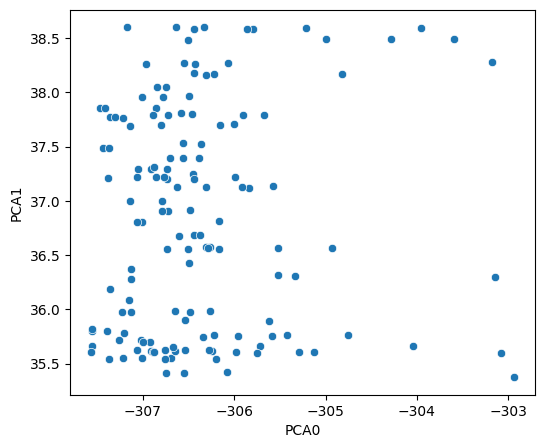

In [164]:
plt.figure(figsize=(6,5))
sns.scatterplot(data=final_df, x='PCA0', y='PCA1', legend=None)
plt.show()

# Merging the datasets and outputting the result

In [165]:
merged_df = pd.merge(df, final_df[['Dep_ID', 'PCA0', 'PCA1']], on='Dep_ID')
merged_df

,Dep_ID,Location,Species,Date_deployed,Time_deployed,Date_retreived,Time_retreived,GPS,TDR,Bill_length,...,season_success,date,year,month,day,colony,Weihgt_change,Location_id,PCA0,PCA1
0,SIC004,"South Orkneys, Signy Island",Chinstrap penguin,30/12/2011,1418,01/01/2012,1345,NaN,A08264,54.6,...,NaN,2011-12-30,2011.0,12.0,30.0,SIC,-0.05,3,-307.168954,38.599218
1,SIC005,"South Orkneys, Signy Island",Chinstrap penguin,30/12/2011,1441,02/01/2012,1520,29309,NaN,46.5,...,NaN,2011-12-30,2011.0,12.0,30.0,SIC,-0.05,3,-306.639931,38.597720
2,SIC008,"South Orkneys, Signy Island",Chinstrap penguin,05/01/2012,1410,08/01/2012,1050,29421,A08265,51.4,...,NaN,2012-01-05,2012.0,1.0,5.0,SIC,0.10,3,-307.549892,35.804248
3,SIC009,"South Orkneys, Signy Island",Chinstrap penguin,05/01/2012,1524,08/01/2012,1340,29417,A08266,51.0,...,NaN,2012-01-05,2012.0,1.0,5.0,SIC,-0.10,3,-307.560179,35.816058
4,SIC010,"South Orkneys, Signy Island",Chinstrap penguin,05/01/2012,1600,08/01/2012,800,IGOTU2,A08264,46.6,...,NaN,2012-01-05,2012.0,1.0,5.0,SIC,0.25,3,-306.365309,37.527933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,PIC063,"South Orkneys, Laurie Island",Chinstrap penguin,31/01/2014,17:00,NaN,NaN,29478,0149,47.5,...,Success,2014-01-31,2014.0,1.0,31.0,PIC,0.55,1,NaN,NaN
211,PIC064,"South Orkneys, Laurie Island",Chinstrap penguin,31/01/2014,17:00,NaN,NaN,29497,0157,50.3,...,Success,2014-01-31,2014.0,1.0,31.0,PIC,0.20,1,NaN,NaN
212,PIC065,"South Orkneys, Laurie Island",Chinstrap penguin,02/04/2014,11:30,NaN,NaN,29640,0157,48.5,...,Success,2014-04-02,2014.0,4.0,2.0,PIC,-0.20,1,NaN,NaN
213,PIC066,"South Orkneys, Laurie Island",Chinstrap penguin,02/04/2014,17:00,NaN,NaN,29452,0148,47.3,...,Success,2014-04-02,2014.0,4.0,2.0,PIC,0.05,1,NaN,NaN


Outputting the result.

In [167]:
merged_df.to_csv('processed_data/meta_pca.csv')